In [2]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        
        # Layer Sizes
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        
        # NN Layers
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        
        # Hyper Parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.batch_size = batch_size
        
        self.mem_size = max_mem_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100
        self.action_space = [i for i in range(n_actions)]

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=256, fc2_dims=256)
        self.Q_next = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=64)

        # Allocate memory arrays
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        '''
        Store each of the arguments in their respective memory arrays.
        '''
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        '''
        Choose an action to take.
        '''
        if np.random.random() > self.epsilon:
            # Choose action based on NN
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state.type(T.float32))
            action = T.argmax(actions).item()
        else:
            # Choose action randomly
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        # Take a random batch of data
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]# Figure this out
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0 # and this

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0] # understand this more

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min

In [4]:
import gym
import numpy as np
import Box2D
from tqdm import trange

In [17]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=output_dim, eps_end=0.01,
              input_dims=[input_dim], lr=0.001)
scores, eps_history = [], []
n_games = 750

for i in (t := trange(n_games)):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])
    t.set_description('episode ' + str(i) + ' average score %.2f' % avg_score)
#     print('episode ', i, 'score %.2f' % score,
#             'average score %.2f' % avg_score,
#             'epsilon %.2f' % agent.epsilon)

episode 193 average score 343.60:  26%|███████████▉                                  | 194/750 [05:59<17:11,  1.86s/it]


KeyboardInterrupt: 

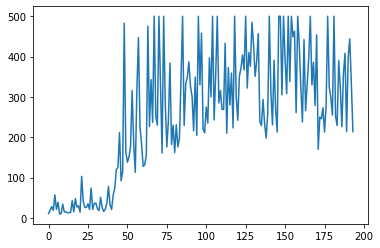

In [18]:
import matplotlib.pyplot as plt
plt.plot(scores)